In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.metrics import  roc_curve, auc ,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes = True)

In [2]:
pima = pd.read_csv('Data/diabetes.csv', sep=';')
df = pd.read_csv('Data/diabetes_pt1.csv', sep=';')
df_test = pd.read_csv('Data/diabetes_pt2.csv', sep=';')

In [3]:
feature_columns = ['Glucose', 'Age', 'BMI', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction']

stan2_data = {
    'N': len(df),
    'X': df[feature_columns].values,
    'y': df['Outcome'].values
}

test2_data = {
    'N': len(df_test),
    'X': df_test[feature_columns].values,
    'y': df_test['Outcome'].values
}

In [4]:
sm2 = CmdStanModel(stan_file='Stan/code_2.stan')

fit2 = sm2.sample(data=stan2_data, iter_sampling=2000, chains=4, iter_warmup=1000)
df3 = fit2.draws_pd()
df3.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_glucose,beta_bmi,...,log_lik[284],log_lik[285],log_lik[286],log_lik[287],log_lik[288],log_lik[289],log_lik[290],log_lik[291],log_lik[292],log_lik[293]
0,-192.220,0.866459,0.074294,5.0,63.0,0.0,200.231,-3.28121,0.013900,0.018756,...,-0.461033,-0.857550,-0.229817,-0.195042,-0.293922,-0.551149,-0.306545,-0.221027,-0.319259,-0.276180
1,-189.069,0.990165,0.074294,5.0,31.0,0.0,194.989,-4.09542,0.019138,0.031998,...,-0.352631,-0.668793,-0.156969,-0.146776,-0.200330,-0.312390,-0.312914,-0.172410,-0.212124,-0.198279
2,-189.511,0.998848,0.074294,6.0,63.0,0.0,192.768,-4.99083,0.028140,0.025618,...,-0.396832,-1.062310,-0.174717,-0.179688,-0.186647,-0.286922,-0.198878,-0.192256,-0.254648,-0.245818
3,-189.615,0.999886,0.074294,5.0,31.0,0.0,190.580,-4.95950,0.028036,0.026202,...,-0.390811,-1.035080,-0.174950,-0.179141,-0.186929,-0.280350,-0.199183,-0.191655,-0.253252,-0.249059
4,-188.093,0.854721,0.074294,5.0,31.0,0.0,192.322,-5.10434,0.028282,0.042260,...,-0.387304,-0.907935,-0.139252,-0.147628,-0.173831,-0.255890,-0.183472,-0.174550,-0.203278,-0.189335


In [5]:
alpha_mean = df3['alpha'].mean()
beta_glucose_mean = df3['beta_glucose'].mean()
beta_age_mean = df3['beta_age'].mean()
beta_bmi_mean = df3['beta_bmi'].mean()
beta_bp_mean = df3['beta_bp'].mean()
beta_insulin_mean = df3['beta_insulin'].mean()
beta_dpf_mean = df3['beta_dpf'].mean()

In [6]:
logit_preds_test = alpha_mean + (test2_data['X'][:, 0] * beta_glucose_mean +
                                 test2_data['X'][:, 1] * beta_age_mean +
                                 test2_data['X'][:, 2] * beta_bmi_mean +
                                 test2_data['X'][:, 3] * beta_bp_mean + 
                                 test2_data['X'][:, 4] * beta_insulin_mean +
                                 test2_data['X'][:, 5] * beta_dpf_mean)

probs_test2 = 1 / (1 + np.exp(-logit_preds_test))

probs_df = pd.DataFrame(probs_test2, columns=['Probability'])
print(probs_df.head())

   Probability
0     0.171723
1     0.266076
2     0.522336
3     0.330481
4     0.205427


In [7]:
preds_test2 = (probs_test2 > 0.5).astype(int)

accuracy = accuracy_score(test2_data['y'], preds_test2)
precision = precision_score(test2_data['y'], preds_test2)
recall = recall_score(test2_data['y'], preds_test2)
f1 = f1_score(test2_data['y'], preds_test2)

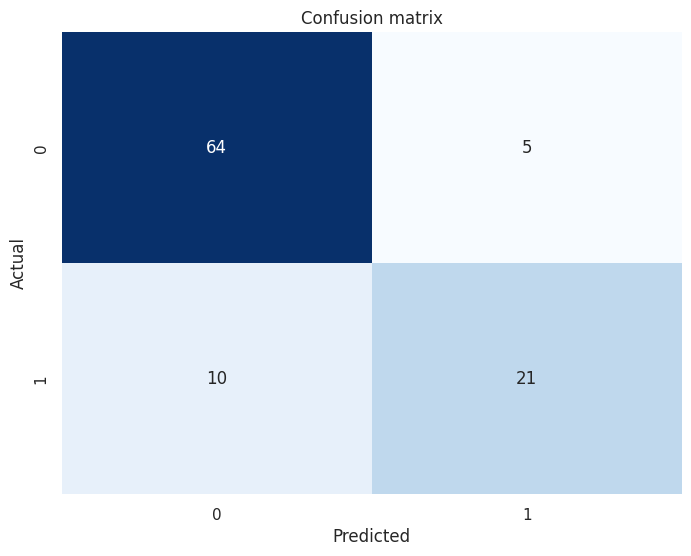

In [8]:

preds_test2 = (probs_test2 > 0.5).astype(int)

conf_matrix = confusion_matrix(test2_data['y'], preds_test2)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
fpr, tpr, _ = roc_curve(test2_data['y'], probs_test2)
roc_auc = auc(fpr, tpr)
 
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.85
Precision: 0.81
Recall: 0.68
F1 Score: 0.74


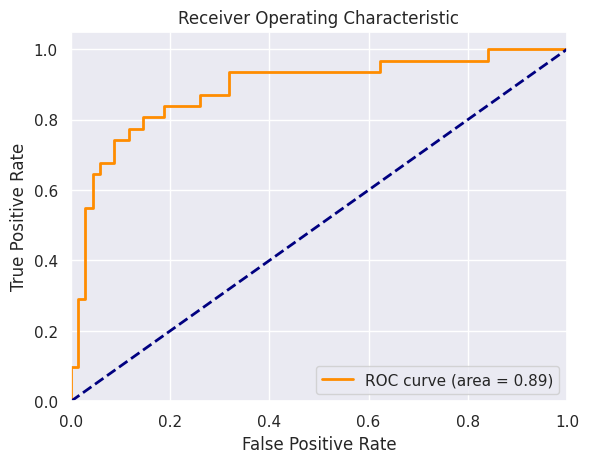

In [10]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()